# Experiment A: Bound Adherence Under Nonstationary Conditions
*Question: does empirical average regret stay within the $\gamma$-regret bounds?*

### Experiment Design
Grid search over the streams (stationary, slow, abrupt, periodic), lambda levels, and two deletion ratio regimes.

Use a static comparator and calibrated learning rate schedule.
Set gamma per-theory at calibration and fix the total horizon (ie. $T=50000$).

### Primary Analysis
For each of the experimental cells, evaluate the final $R_{T}/T$ to see whether the guarantee was met.
Multiple seeds per cell in order to make some kind of causal analysis on the results.

### Success Criteria
95% of the cells meet their guarantees then I would call that a success. Which cells experience more successes than others? Can I make a heatmap that shows the regret results per cell?

## Import Statements and Versioning

This uses pretty standard library imports, but the torch requirement can stress the memory limits of a host.

In [1]:
# set global seed
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

def set_seed(seed):
    """
    Set the random seed for reproducibility.
    
    Args:
        seed (int): The seed value to set for random number generation.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Config and Target

In [2]:
RUN_ID = "experiment_a_test"
REGIME = "stationary"
REPLICATE = 1
T = 1000
SEED = 42
LOSS_NAME = "logistic"
MODEL_NAME = "memorypair"
LBFGS_MEM = 10

# Setup and Imports

In [3]:
# Import required modules
import sys
import os

# Add code path for imports
os.chdir(os.path.dirname(os.getcwd()))

from config import Config
from runner import ExperimentRunner

from agents.grid_runner import load_grid, generate_combinations, create_grid_id, run_parameter_combination


## Reading and Transforming the Data 

The data is now in a series of files in the results folder. This section will read in those datapoints and output a fully formatted dataframe of a random sample of the datapoints.

Analysis can be performed in batches.

In [4]:
# print a count of all directories in the results directory
dir_list = []
results_dir = "results/grid_2025_01_01/sweep/gamma_1.0-split_0.3_q0.90_k3_eps_delta_eps1.0_cmpstatic_orcon_prot_ang0.01_dr0.001_fs1_h1f8d6c1e"
for r, d, files in os.walk(results_dir):
    for dirname in d:
        dir_list.append(os.path.join(r, dirname))
print(f"Number of directories in '{results_dir}': {len(dir_list)}")
print(dir_list)

Number of directories in 'results/grid_2025_01_01/sweep/gamma_1.0-split_0.3_q0.90_k3_eps_delta_eps1.0_cmpstatic_orcon_prot_ang0.01_dr0.001_fs1_h1f8d6c1e': 0
[]


In [42]:
# read the files from one folder in particular
data = []
seed_data = []
results_dir = "results/grid_2025_01_01/sweep/gamma_1.0-split_0.3_q0.90_k3_eps_delta_eps1.0_cmpstatic_orcon_prot_ang0.01_dr0.001_fs1_h1f8d6c1e"
for f in os.listdir(results_dir):
    if f.endswith('eps1.0.csv'):
        df = pd.read_csv(os.path.join(results_dir, f))
        df["seed"] = int(f.split("_")[1])
        data.append(df)
    elif f.endswith('.csv'):
        df = pd.read_csv(os.path.join(results_dir, f))
        df["seed"] = int(f.split("_")[1].split(".")[0])
        seed_data.append(df)

# concatenate all event dataframes
if data:
    data = pd.concat(data, ignore_index=True)
    seed_data = pd.concat(seed_data, ignore_index = True)
else:
    data = pd.DataFrame()

cols_to_use = list(seed_data.columns.difference(data.columns))
cols_to_use.append("seed")
# join on the seed
data = data.merge(seed_data[cols_to_use], on="seed", how="left")


In [43]:
seed_data

,seed,grid_id,avg_regret_empirical,N_star_emp,m_emp,final_acc,total_events,gamma_bar,gamma_split,accountant,...,drift_rate,feature_scale,w_scale,fix_w_norm,noise_std,eps_spent,eps_remaining,delta_total,N_star_theory,eta_t
0,4,gamma_1.0-split_0.3_q0.90_k3_eps_delta_eps1.0_...,5.979191,3936,1311,6.907012,9950,1.0,0.3,eps_delta,...,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.00001,4703.0,0.000612
1,0,gamma_1.0-split_0.3_q0.90_k3_eps_delta_eps1.0_...,3.044853,6370,2123,5.139072,9950,1.0,0.3,eps_delta,...,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.00001,1457.0,0.000910
2,2,gamma_1.0-split_0.3_q0.90_k3_eps_delta_eps1.0_...,3.288995,5571,1856,2.613332,9950,1.0,0.3,eps_delta,...,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.00001,2523.0,0.000844


In [44]:
print(data.columns)

Index(['C_hat', 'D_hat', 'G_hat', 'N_gamma', 'N_star_theory', 'P_T', 'P_T_est',
       'S_scalar', 'acc', 'accountant', 'avg_regret', 'avg_regret_with_noise',
       'base_eta_t', 'c_hat', 'comparator_type', 'cum_regret',
       'cum_regret_with_noise', 'd_norm', 'delta_step_theory', 'delta_total',
       'drift_boost_remaining', 'drift_flag', 'eps_remaining', 'eps_spent',
       'eps_step_theory', 'eta_t', 'event', 'event_id', 'event_type',
       'events_seen', 'is_calibrated', 'lambda_est', 'lambda_raw',
       'm_capacity', 'm_used', 'noise_regret_cum', 'noise_regret_increment',
       'op', 'pair_admitted', 'pair_damped', 'path_regret_increment', 'regret',
       'regret_dynamic', 'regret_increment', 'regret_path_term',
       'regret_static_term', 'rho_remaining', 'rho_spent', 'rho_step',
       'sample_id', 'sc_active', 'sc_stable', 'segment_id', 'sens_delete',
       'sigma_step', 'sigma_step_theory', 'static_oracle_norm',
       'static_regret_increment', 'x_norm', 'seed', 'N_

In [45]:
# print segment id counts
print(data["seed"].value_counts())

seed
2    9950
3    9950
0    9950
1    9950
4    9950
Name: count, dtype: int64


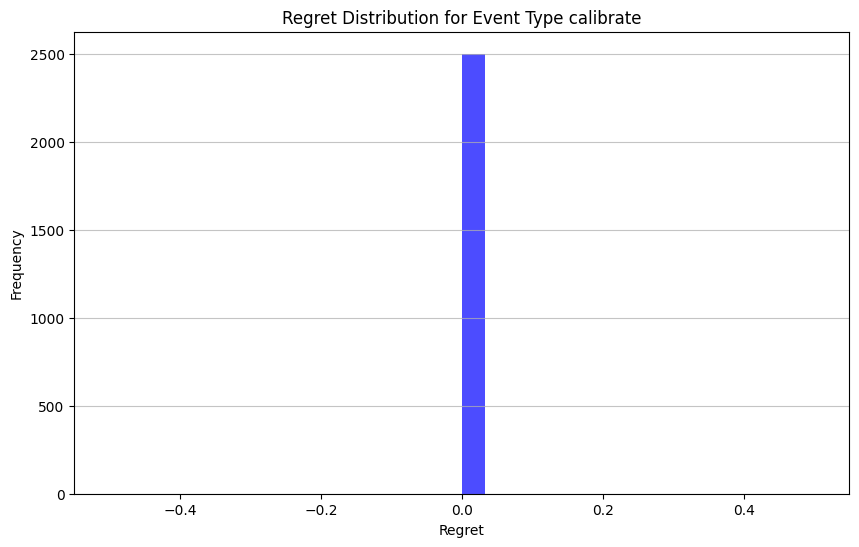

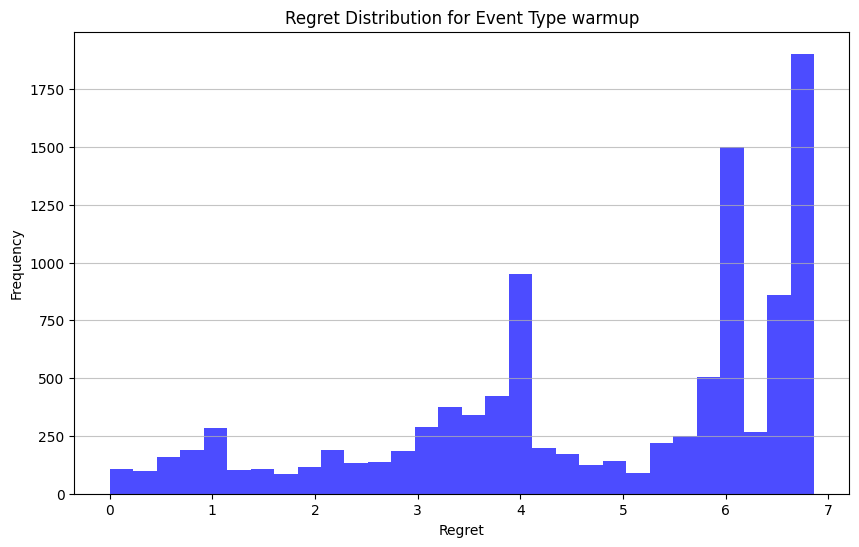

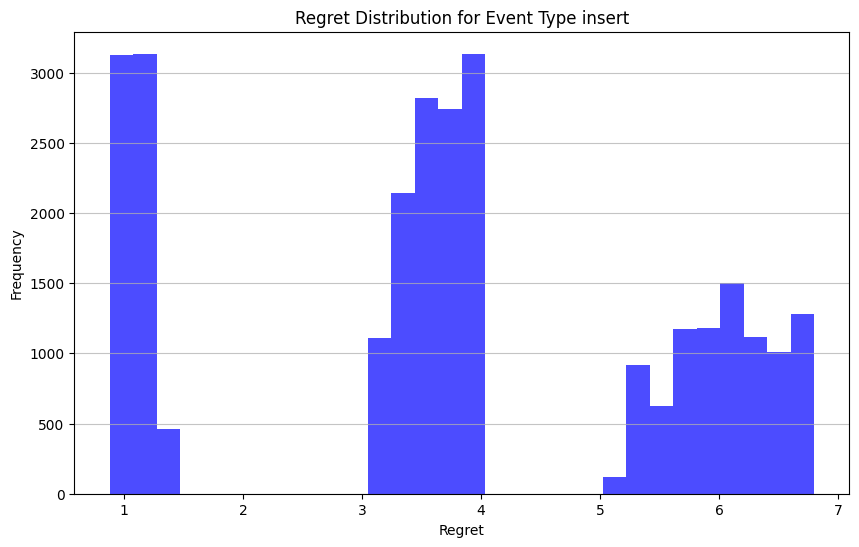

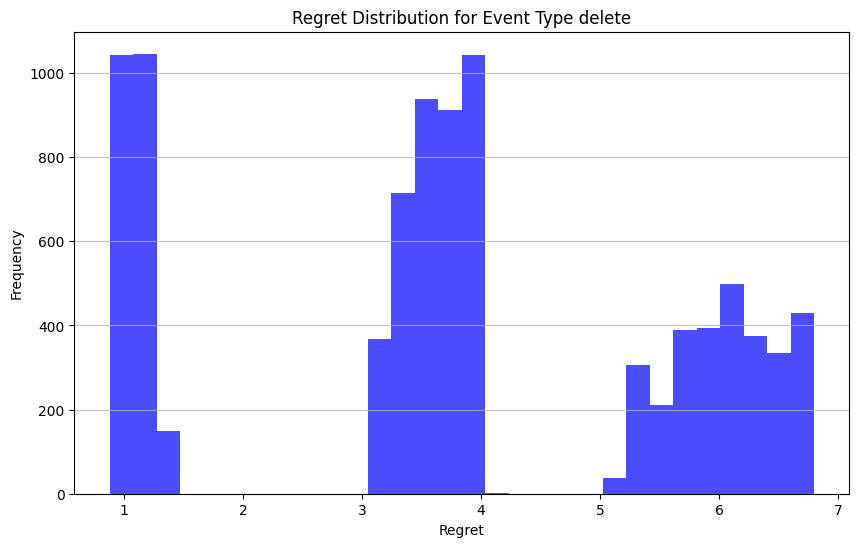

In [51]:
# plot regret distribution for each event type
import matplotlib.pyplot as plt

for event_type in data["event_type"].unique():
    plt.figure(figsize=(10, 6))
    plt.hist(data[data["event_type"] == event_type]["avg_regret"], bins=30, alpha=0.7, color='blue')
    plt.title(f"Regret Distribution for Event Type {event_type}")
    plt.xlabel("Regret")
    plt.ylabel("Frequency")
    plt.grid(axis='y', alpha=0.75)
    plt.show()

In [46]:
regret = data[["event", "regret", "grid_id"]]

# count unique grid IDs
print(regret["grid_id"].nunique())
regret.describe()
regret.head()

1


,event,regret,grid_id
0,0,0.0,gamma_1.0-split_0.3_q0.90_k3_eps_delta_eps1.0_...
1,1,0.0,gamma_1.0-split_0.3_q0.90_k3_eps_delta_eps1.0_...
2,2,0.0,gamma_1.0-split_0.3_q0.90_k3_eps_delta_eps1.0_...
3,3,0.0,gamma_1.0-split_0.3_q0.90_k3_eps_delta_eps1.0_...
4,4,0.0,gamma_1.0-split_0.3_q0.90_k3_eps_delta_eps1.0_...


KeyboardInterrupt: 

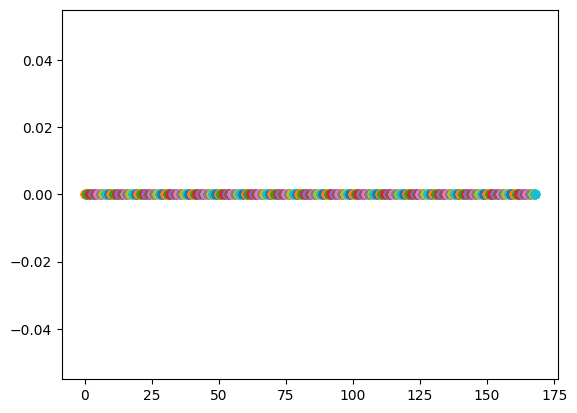

In [8]:
# plot regret against event by sample ID
import matplotlib.pyplot as plt
for segment_id in regret["sample_id"].unique():
    plt.scatter(
        regret[regret["sample_id"] == segment_id]["event"],
        regret[regret["sample_id"] == segment_id]["regret"],
        label=f"Segment {segment_id}"
    )
plt.show()